## Занятие 11. Инференс нейросетей

### 1. Описание проблемы
Инференс нейросетей может выполняться очень по-разному:

1. **С помощью какого фреймворка и ЯП обучена сеть?** 
    Например: PyTorch, Tensorflow, JAX, PaddlePaddle, NeoML

2. **На каком вычислителе выполняется инференс?**
    Например: x86, ARM, GPU, TPU, специализированные ускорители ([NPU](https://en.wikipedia.org/wiki/AI_accelerator))

3. **В каком окружении происходит вызов?**
    Например: bare-metal микроконтроллер без OS - или в Docker контейнере в Kubernetes


Обычно хочется выполнять инференс:
- эффективно для разных окружений и ускорителей 
- единообразно для разных сетей

Из-за множества разных комбинаций появляются как специализированные продукты ([ArmNN](https://developer.arm.com/Tools%20and%20Software/ArmNN)) для отдельных сценариев, так и универсальные решения.

### 2. Open Neural Network Exchange
ONNX(https://github.com/onnx/) - открытый расширяемый стандарт описания нейронных сетей, а также экосистема из многих программных продуктов для поддержки стандарта.

Нейросети определяются как вычислительный граф операторов над данными.

Пример оператора Conv: https://github.com/onnx/onnx/blob/main/docs/Operators.md#conv

Пример расширения стандарта кастомным оператором: 
Conv NHWC: https://github.com/microsoft/onnxruntime/blob/main/docs/ContribOperators.md#com.microsoft.NhwcConv


In [1]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
import onnx
from matplotlib import pyplot as plt

In [2]:
model = smp.Linknet(
    encoder_name='mobilenet_v2', 
    encoder_weights='imagenet', 
    classes=8, 
    activation='softmax'
).eval()

model.load_state_dict(torch.load('swim_linknet.state_dict'))#

<All keys matched successfully>

torch.Size([1, 3, 256, 256])

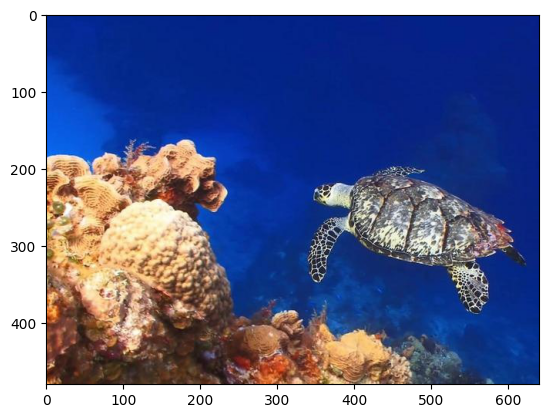

In [42]:
img = plt.imread('f_r_74_.jpg').astype(np.float32) / 255
plt.imshow(img)

from torchvision import transforms
x0 = torch.tensor(img).permute(2, 0, 1)[None]
x_bt = transforms.functional.resize(
    x0, size=(256, 256), 
    interpolation=transforms.functional.InterpolationMode.BILINEAR
)

x_bt.shape

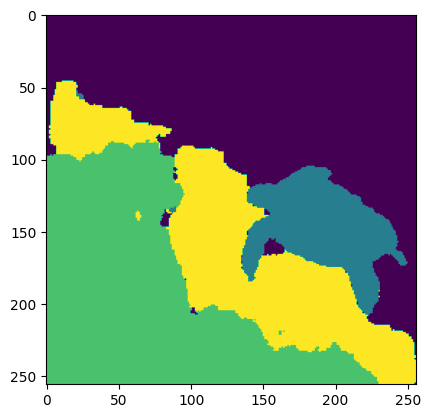

In [43]:
with torch.no_grad():
    yp = model(x_bt)[0]
plt.imshow(np.argmax(yp, axis=0))

In [44]:
y = model(x_bt)
y.shape

torch.Size([1, 8, 256, 256])

In [45]:
torch.onnx.export(
    model, x_bt, "linknet.onnx",
    input_names=['image'], output_names=['mask']
)

Конвертация выполняется с помощью отслеживания (Tracing) операций.
Warning стоит читать - они могут означать, что конвертированная операция работает иначе, чем оригинал

Сконвертированную модель можно визуализировать - например, с помощью https://github.com/lutzroeder/netron

Можно открыть модель программно с помощью пакета `onnx` (https://github.com/onnx/onnx)


In [46]:
model_onnx_spec = onnx.load('linknet.onnx')
onnx.checker.check_model(model_onnx_spec)

In [47]:
input_all = [node.name for node in model_onnx_spec.graph.input]
input_all

['image']

In [48]:
output_all = [node.name for node in model_onnx_spec.graph.output]
output_all

['mask']

ONNX - формат определения (описания) модели.

Непосредственно инференс модели - отдельная задача, которая может выполняться любыми движками инференса, поддерживающими onnx.

Наиболее популярный и user-friendy движок - `onnxruntime` (https://github.com/microsoft/onnxruntime)

In [49]:
import onnxruntime as ort
from pathlib import Path
import os
import torch 
import numpy as np
from matplotlib import pyplot as plt

In [23]:
ort_sess = ort.InferenceSession(
    'linknet.onnx', 
    providers=['CPUExecutionProvider']
)


Вход: torch.Size([1, 3, 256, 256]), Выход (1, 8, 256, 256)


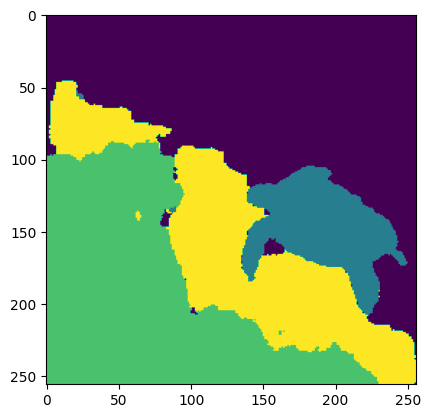

In [51]:
outputs = ort_sess.run(output_names=['mask'], input_feed={'image': x_bt.numpy()})
print(f"Вход: {x_bt.shape}, Выход {outputs[0].shape}")
plt.imshow(np.argmax(outputs[0][0], axis=0))

### Динамические оси
По умолчанию считается, что все тензоры имеют статический размер.

Использование иного размера **вызывает ошибку.**

In [52]:
outputs = ort_sess.run(
    output_names=['mask'], 
    input_feed={'image': np.random.rand(1, 3, 300, 300).astype(np.float32)}
)

RuntimeException: [ONNXRuntimeError] : 6 : RUNTIME_EXCEPTION : Non-zero status code returned while running Add node. Name:'/decoder/blocks.0/Add' Status Message: D:\a\_work\1\s\onnxruntime\core/providers/cpu/math/element_wise_ops.h:523 onnxruntime::BroadcastIterator::Append axis == 1 || axis == largest was false. Attempting to broadcast an axis by a dimension other than 1. 19 by 20


In [53]:
torch.onnx.export(
    model, img_t, "linknet_dynamic_hw.onnx",
    input_names=['image'], output_names=['mask'],
    dynamic_axes={'image': [0, 2, 3]}
)

Вход: torch.Size([1, 3, 224, 288]), Выход (1, 8, 224, 288)


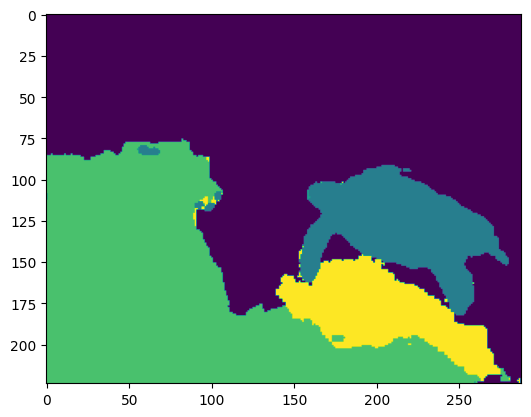

In [55]:
x_bt = transforms.functional.resize(
    x0, size=(224, 288), 
    interpolation=transforms.functional.InterpolationMode.BILINEAR
)
ort_sess = ort.InferenceSession(
    'linknet_dynamic_hw.onnx', 
    providers=['CPUExecutionProvider']
)
outputs = ort_sess.run(
    output_names=['mask'], 
    input_feed={'image': x_bt.numpy()}
)
outputs[0].shape
print(f"Вход: {x_bt.shape}, Выход {outputs[0].shape}")
plt.imshow(np.argmax(outputs[0][0], axis=0))

ONNX позволяет строить разные графы - но tracing кода на torch не всегда срабатывает корректно.

Часто проблемы возникают с динамическими осями.
#### Пример ошибочной конвертации

In [58]:
model_mbn = smp.Linknet(
    encoder_name='timm-mobilenetv3_small_minimal_100', # Другой энкодер - из стандартных timm
    encoder_weights='imagenet', 
    classes=8, 
    activation='softmax'
)

torch.onnx.export(
    model_mbn, img_t, "linknet_dynamic_hw_mbn_timm.onnx",
    input_names=['image'], output_names=['mask'],
    dynamic_axes={'image': [2, 3]}
)

In [59]:
ort_sess = ort.InferenceSession(
    'linknet_dynamic_hw_mbn_timm.onnx', 
    providers=['CPUExecutionProvider']
)

x = np.random.rand(1, 3, 224, 224).astype(np.float32)
outputs = ort_sess.run(
    output_names=['mask'], 
    input_feed={'image': x}
)
print(f"Вход: {x.shape}, Выход {outputs[0].shape}")


x = np.random.rand(1, 3, 320, 320).astype(np.float32)
outputs = ort_sess.run(
    output_names=['mask'], 
    input_feed={'image': x}
)
print(f"Вход: {x.shape}, Выход {outputs[0].shape}") 

Вход: (1, 3, 224, 224), Выход (1, 8, 224, 224)
Вход: (1, 3, 320, 320), Выход (1, 8, 224, 224)


In [60]:
# Conv-same с stride=2 - требует не тривиальных вычислений в общем случае
model_mbn.encoder.model.conv_stem

Conv2dSame(3, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)

Причина проблемы в данном случае - использование динамического padding, определяемого Shape.

https://github.com/rwightman/pytorch-image-models/blob/main/timm/models/layers/conv2d_same.py#L16

Исправить неверную конвертацию затруднительно - обычно проще не использовать такие сложные конструкции в модели. 

1. **Тестируйте модель после конвертации в ONNX**
1. **Проверяйте визуализации графа ONNX на разумность**


### 3.Задачка: исправьте конвертацию модели

In [61]:
class NormalizedVectorSum(torch.nn.Module):
    """
    Принимает батч векторов X[N, S]
    Возвращает сумму всех элементов, нормированную на количество элментов тензора.
    Y[0] = Sum(X[n, i]) / (N * S)
    """
    def forward(self, ns_t: torch.Tensor) -> torch.Tensor:
        norm = float(ns_t.nelement())
        return torch.sum(ns_t, axis=[0, 1], keepdims=True) / norm


In [62]:
nvs = NormalizedVectorSum()
x_t = torch.rand(4, 546)

In [63]:
torch.onnx.export(
    nvs, x_t, "nvs.onnx",
    input_names=['batch_vectors'], output_names=['result'],
    dynamic_axes={'batch_vectors': [0, 1]}
)

C:\Users\bzimka\Anaconda3\envs\torchedu39\lib\site-packages\torch\onnx\utils.py:2020: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input batch_vectors
  warnings.warn(
C:\Users\bzimka\AppData\Local\Temp\ipykernel_8324\3890584856.py:8: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  norm = float(ns_t.nelement())


In [64]:
ort_sess = ort.InferenceSession(
    'nvs.onnx', 
    providers=['CPUExecutionProvider']
)

outputs = ort_sess.run(
    output_names=['result'], 
    input_feed={'batch_vectors': x_t.numpy()}
)
print(f"ORT: {outputs[0]}, torch:{nvs(x_t)}") 

ORT: [[0.49419954]], torch:tensor([[0.4942]])


In [65]:
x_t = torch.rand(3, 1200)

outputs = ort_sess.run(
    output_names=['result'], 
    input_feed={'batch_vectors': x_t.numpy()}
)
print(f"ORT: {outputs[0]}, torch: {nvs(x_t)}") 

ORT: [[0.80776256]], torch: tensor([[0.4900]])


### 4.Сравнение скорости torch и onnxruntime

In [103]:
%%writefile {Path().absolute() / 'runners.py'}

import time
import torch
import numpy as np

class TorchRunner:
    """
    Запуск модели с замерами времени
    """
    def __init__(self, net, device):
        self.net = net
        self.device = device
    
    def __call__(self, x: np.ndarray):
        x_t = torch.tensor(x, device=self.device)
        with torch.no_grad():
            y_t = self.net(x_t).cpu().numpy()
        return y_t
    
    @classmethod
    def measure_times(cls, samples, freq=10, **cls_kwargs):
        runner = cls(**cls_kwargs)
        start = time.time_ns()
        
        times = []
        
        start0 = time.time_ns()
        start = start0
        for num, s in enumerate(samples):
            y = runner(s)
            if ((num + 1) % freq) == 0:
                times.append((time.time_ns() - start)/freq /1e6)
                start = time.time_ns()
                
        print(f"Average time: {(time.time_ns() - start0) / (num + 1) / 1e6}")
        return times
    
class OrtRunner(TorchRunner):
    def __init__(self, ort_inference_session, input_name):
        self.session = ort_inference_session
        self.input_name = input_name
    
    def __call__(self, x: np.ndarray):
        outputs = self.session.run(
            output_names=None,
            input_feed={self.input_name: x}
        )
        return outputs
    

Overwriting D:\edu\teach\course_cvdl\classes\c11\runners.py


In [104]:
from runners import OrtRunner, TorchRunner

In [97]:
N_TIMES = 100
SHAPE = (1, 3, 224*3, 224*3)
RESULTS = dict()

Average time: 372.248913


Text(0.5, 0, 'ms')

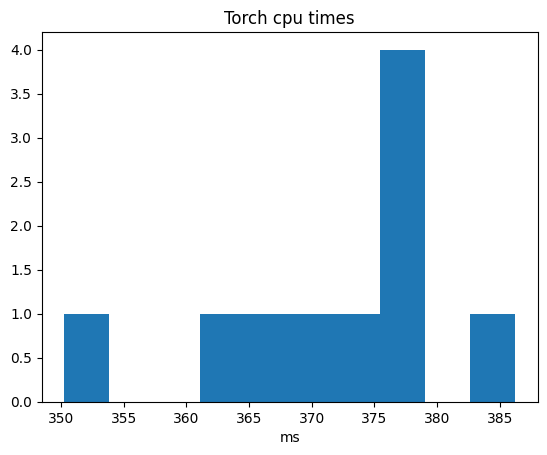

In [98]:
RESULTS['torch_cpu'] = TorchRunner.measure_times(
    (np.random.rand(*SHAPE).astype(np.float32) for _ in range(N_TIMES)),
    net=model.to('cpu'), 
    device=torch.device('cpu'),
)
plt.hist(RESULTS['torch_cpu'])
plt.title('Torch cpu times')
plt.xlabel('ms')

Average time: 28.681409


Text(0.5, 0, 'ms')

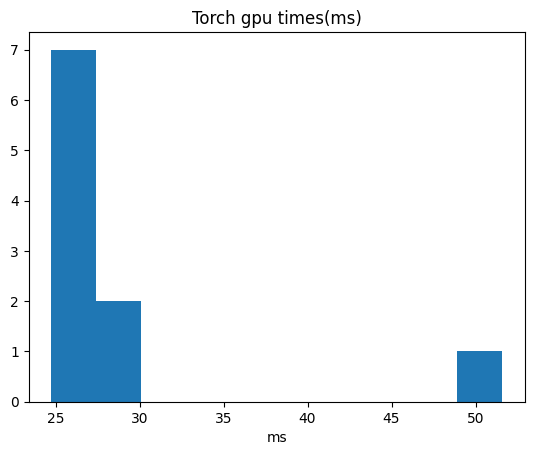

In [99]:
RESULTS['torch_gpu'] = TorchRunner.measure_times(
    (np.random.rand(*SHAPE).astype(np.float32) for _ in range(N_TIMES)),
    net=model.to('cuda:0'), 
    device=torch.device('cuda:0'),
)
plt.hist(RESULTS['torch_gpu'])
plt.title('Torch gpu times(ms)')
plt.xlabel('ms')

In [100]:
if SHAPE == (1, 3, 224, 224):
    RESULTS['ort_cpu'] = OrtRunner.measure_times(
        (np.random.rand(*SHAPE).astype(np.float32) for _ in range(N_TIMES)),
        ort_inference_session=ort.InferenceSession(
            'linknet.onnx', 
            providers=['CPUExecutionProvider']
        ),
        input_name='image'
    )
    plt.hist(RESULTS['ort_cpu'])
    plt.title('ORT cpu times')
else:
    print("Static axis require specific shape")

Static axis require specific shape


Average time: 125.002202


Text(0.5, 1.0, 'ORT cpu dynamic times')

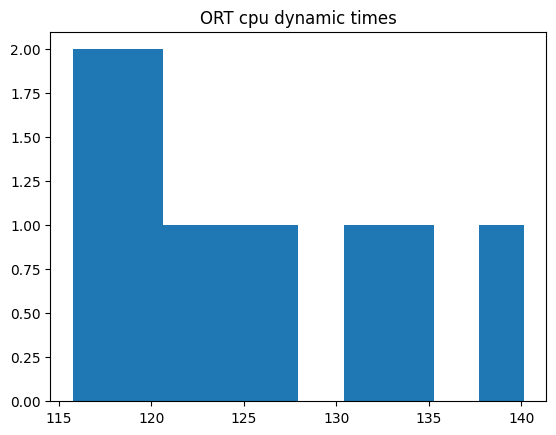

In [101]:
RESULTS['ort_cpu_dynamic'] = OrtRunner.measure_times(
    (np.random.rand(*SHAPE).astype(np.float32) for _ in range(N_TIMES)),
    ort_inference_session=ort.InferenceSession(
        'linknet_dynamic_hw.onnx', 
        providers=['CPUExecutionProvider']
    ),
    input_name='image'
)
plt.hist(RESULTS['ort_cpu_dynamic'])
plt.title('ORT cpu dynamic times')

Average time: 125.373376


Text(0.5, 1.0, 'ORT cuda times')

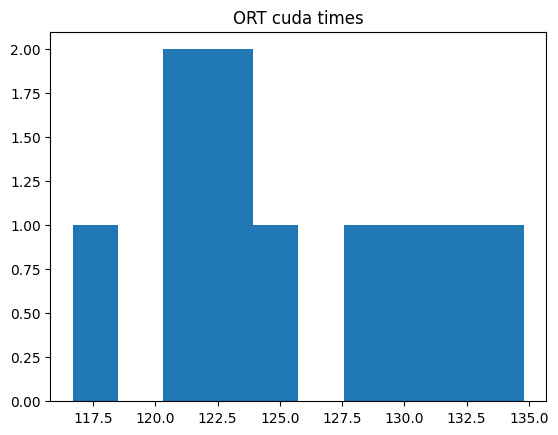

In [102]:
RESULTS['ort_cuda_dynamic'] = OrtRunner.measure_times(
    (np.random.rand(*SHAPE).astype(np.float32) for _ in range(N_TIMES)),
    ort_inference_session=ort.InferenceSession(
        'linknet_dynamic_hw.onnx', 
        providers=['CUDAExecutionProvider']
    ),
    input_name='image'
)
plt.hist(RESULTS['ort_cuda_dynamic'])
plt.title('ORT cuda times')

## 5. Использование ONNXRuntime providers
ORT может использовать различные сторонние проекты в качестве provider: https://onnxruntime.ai/docs/execution-providers/

В такмом варианте OnnxRuntime служит общим интерфейсом к разным инференс движками.

Пример - Intel OpenVino provider

RESTART

## RESTART notebook

In [1]:
import openvino.utils as utils
utils.add_openvino_libs_to_path()

In [7]:
import onnxruntime as ort
from pathlib import Path
import os
import torch 
import numpy as np
from matplotlib import pyplot as plt

from runners import OrtRunner, TorchRunner
N_TIMES = 100
SHAPE = (1, 3, 256 * 3, 256 * 3)

In [8]:
ort.get_available_providers()

['OpenVINOExecutionProvider', 'CPUExecutionProvider']

Average time: 180.079167


Text(0.5, 1.0, 'Basic cpu dynamic times')

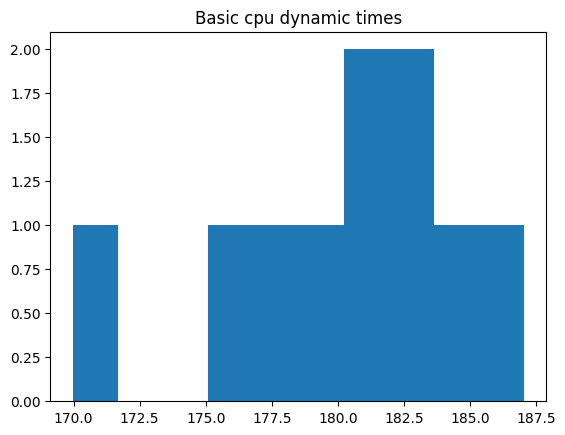

In [9]:
plt.hist(
    OrtRunner.measure_times(
        (np.random.rand(*SHAPE).astype(np.float32) for _ in range(N_TIMES)),
        ort_inference_session=ort.InferenceSession(
            'linknet_dynamic_hw.onnx', 
            providers=['CPUExecutionProvider']
        ),
        input_name='image'
    )
)
plt.title('Basic cpu dynamic times')

Average time: 81.705611


Text(0.5, 1.0, 'OpenVINO cpu dynamic times')

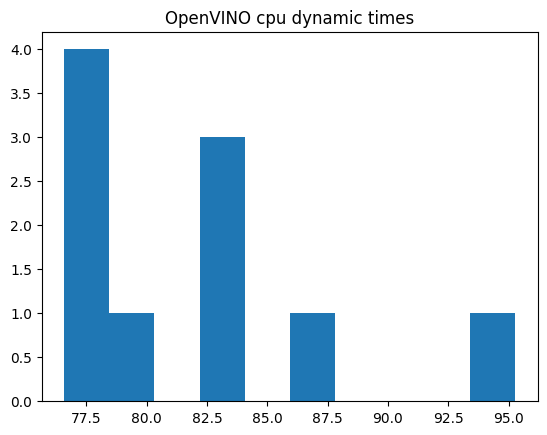

In [10]:
plt.hist(
    OrtRunner.measure_times(
        (np.random.rand(*SHAPE).astype(np.float32) for _ in range(N_TIMES)),
        ort_inference_session=ort.InferenceSession(
            'linknet_dynamic_hw.onnx', 
            providers=['OpenVINOExecutionProvider']
        ),
        input_name='image'
    )
)
plt.title('OpenVINO cpu dynamic times')

### 6. Оптимизация моделей

В ORT есть опция включения ряда оптимизация графа.

Average time: 181.80474


Text(0.5, 1.0, 'ORT cpu optimized dynamic times')

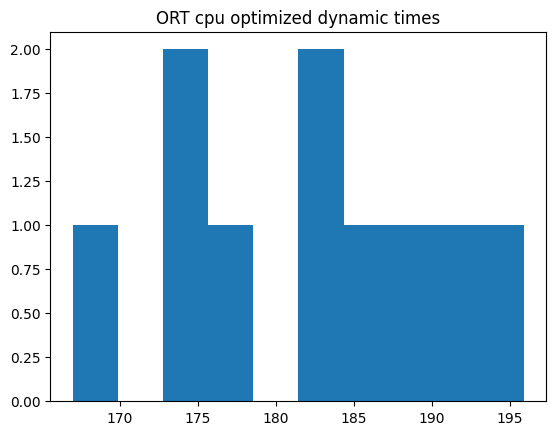

In [11]:
sess_options = ort.SessionOptions()

sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL

plt.hist(
    OrtRunner.measure_times(
        (np.random.rand(*SHAPE).astype(np.float32) for _ in range(N_TIMES)),
        ort_inference_session=ort.InferenceSession(
            'linknet_dynamic_hw.onnx', 
            providers=['CPUExecutionProvider'],
            session_options=sess_options
        ),
        input_name='image'
    )
)
plt.title('ORT cpu optimized dynamic times')

In [12]:
! pip install onnxsim

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [13]:
! onnxsim linknet_dynamic_hw_mbn_timm.onnx linknet_dynamic_hw_mbn_timm_optim.onnx

Your model contains "Tile" ops or/and "ConstantOfShape" ops. Folding these ops 
can make the simplified model much larger. If it is not expected, please 
specify "--no-large-tensor" (which will lose some optimization chances)
Simplifying...
Finish! Here is the difference:
+--------------------------------------------------------+
|                    | Original Model | Simplified Model |
|--------------------+----------------+------------------|
| Add                | 10             | 10               |
| BatchNormalization | 5              | 5                |
| Cast               | 30             | 0                |
| Concat             | 15             | 5                |
| Constant           | 115            | 0                |
| ConstantOfShape    | 5              | 0                |
| Conv               | 45             | 45               |
| ConvTranspose      | 5              | 5                |
| Div                | 10             | 10               |
| Gather           

### 7. Model Serving
Частый сценарий инференса - вызов через сетевой интерфейс, т.е. REST/gRPC API поверх HTTP

Пример:
- запрос из мобильного приложения к облачному веб-сервису на сервере с GPU
- запрос из одного микросервиса Kubernetes к микросервису вычислений
- запрос из jupyter-notebook к модели на подключённой к локальной сети RaspberryPi

Плюсы:
- контролируемое и масштабируемое окружение
- конфиденциальность модели и данных

Для этого сценария есть отдельные более специализированные решения.
Примеры:
- tensorflow-serving, torchserve
- nvidia [triton](https://github.com/triton-inference-server/server)
- kserve, [bentoml](https://www.bentoml.com/), seldom

Обычно решаются несколько другие проблемы, например:
- батчинг запросов (несколько клиентов - один батч на GPU)
- очереди, асинхронные запрос-ответы
- автомасштабирование при превышении Requests-per-second
- мониторинг памяти / производительности


### Пример: bentoml
Использует onnxruntime как один из backend

In [3]:
import onnx
import numpy as np

In [4]:
model_onnx_spec = onnx.load('linknet_dynamic_hw.onnx')

In [5]:
import bentoml
import onnxruntime

signatures = {
    "run": {"batchable": True},
}
bentoml.onnx.save_model("linknet", model_onnx_spec, signatures=signatures)

Model(tag="linknet:d653kqturc2ebkc6", path="C:\Users\bzimka\bentoml\models\linknet\d653kqturc2ebkc6\")

In [6]:
%%writefile linkenet_service.py
import bentoml

import numpy as np
from bentoml.io import NumpyNdarray

bento_model = bentoml.onnx.get("linknet:latest")
runner = bento_model.with_options(providers=["CPUExecutionProvider"]).to_runner()
svc = bentoml.Service("linknet", runners=[runner])

@svc.api(input=NumpyNdarray(), output=NumpyNdarray())
async def segment(x) -> np.ndarray:
    y = await runner.run.async_run(np.array(x))
    return y

Overwriting linkenet_service.py


In [7]:
from matplotlib import pyplot as plt
import torch
from torchvision import transforms

img = plt.imread('f_r_74_.jpg').astype(np.float32) / 255
from torchvision import transforms
x0 = torch.tensor(img).permute(2, 0, 1)[None]
x_bt = transforms.functional.resize(
    x0, size=(256, 256), 
    interpolation=transforms.functional.InterpolationMode.BILINEAR
)

'Runner.init_local' is for debugging and testing only. Make sure to remove it before deploying to production.
C:\Users\bzimka\Anaconda3\envs\torchedu39\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:54: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


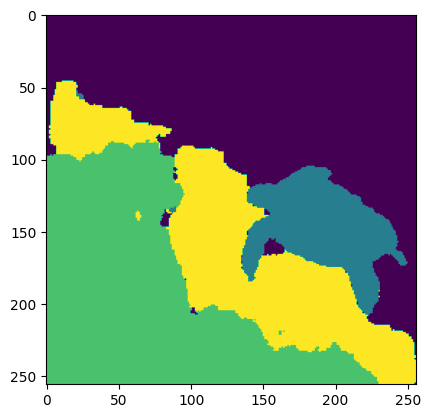

In [8]:
runner = bentoml.onnx.get("linknet").to_runner()

runner.init_local()

y = runner.run.run(x_bt.numpy())[0]
plt.imshow(np.argmax(y, axis=0))

In [9]:
del runner

python -m bentoml serve-grpc linkenet_service:svc --reload --enable-reflection

In [12]:
import grpc
import numpy as np
from bentoml.grpc.utils import import_generated_stubs
from bentoml.io import NumpyNdarray

pb, services = import_generated_stubs()


In [13]:
with grpc.insecure_channel("localhost:3000") as channel:
    stub = services.BentoServiceStub(channel)

    req: pb.Response = stub.Call(
        request=pb.Request(
            api_name="segment",
            ndarray=pb.NDArray(
               dtype=pb.NDArray.DTYPE_FLOAT,
               shape=(1, 3, 256, 256),
               float_values=x_bt.numpy().flatten()
            ),
      )
    )
    response = await NumpyNdarray().from_proto(req.ndarray)
response.shape

(1, 8, 256, 256)

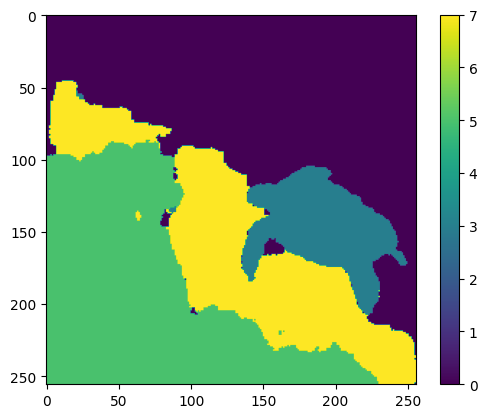

In [16]:
plt.imshow(np.argmax(response[0], axis=0))
plt.colorbar()